In [198]:
import pandas as pd
import pickle
import numpy as np
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import torch
import torch.nn as nn

In [199]:
# contenedor

resultados = pd.DataFrame(index=['M. Zonal', 'M. Parcela'], columns=['Temperatura1', 'HR1', 'Precipitacion1', 'Temperatura2', 'HR2', 'Precipitacion2'])

columns = [('MSE(y_real, AEMET)', 'Temperatura1'), ('MSE(y_real, AEMET)', 'HR1'), ('MSE(y_real, AEMET)', 'Precipitacion1'),
           ('MSE(y_real, y_pred)', 'Temperatura2'), ('MSE(y_real, y_pred)', 'HR2'), ('MSE(y_real, y_pred)', 'Precipitacion2')]
resultados.columns = pd.MultiIndex.from_tuples(columns)

### Evaluacion del modelo zonal

In [200]:
with open("/home/diego/weather-control/experiments/experimentoFINAL/zmodel/outputs/best/prediccion_test.pickle", 'rb') as handler:
    predicciones = pickle.load(handler)

In [201]:
y_pred, y_real, y_nwp = predicciones['y_pred'], predicciones['y_real'], predicciones['y_nwp']
weights = torch.tensor([1/150541, 1/1621, 1/512, 1/249, 1/176, 1/121, 1/46, 1/1])
MAE_t_z, MAE_hr_z, CEL_r_z = [], [], []
for idx in tqdm(range(len(y_pred))):
    MAE_t_z.append(mean_absolute_error(np.mean(y_real[idx][..., 0], axis=0).reshape(-1,1), np.mean(y_nwp[idx][...,0], axis=0).reshape(-1,1)))
    MAE_hr_z.append(mean_absolute_error(np.mean(y_real[idx][..., 1], axis=0).reshape(-1,1), np.mean(y_nwp[idx][...,1], axis=0).reshape(-1,1)))
    real = y_real[idx][..., 2:].astype(np.float32)
    real = torch.from_numpy(real) + 0.02
    real = real.reshape(-1, 8).float()
    nwp = y_nwp[idx][..., 2:].astype(np.float32)
    nwp = torch.from_numpy(nwp)
    nwp = torch.argmax(nwp, dim=-1).reshape(-1, 1).squeeze().type(torch.long)
    CEL_r_z.append(nn.CrossEntropyLoss(weight=weights)(real, nwp).numpy())

resultados.loc['M. Zonal', [['MSE(y_real, AEMET)', 'Temperatura1']]] = np.mean(MAE_t_z, axis=0) * 100
resultados.loc['M. Zonal', [['MSE(y_real, AEMET)', 'HR1']]] = np.mean(MAE_hr_z, axis=0) * 100
resultados.loc['M. Zonal', [['MSE(y_real, AEMET)', 'Precipitacion1']]] = np.mean(CEL_r_z, axis=0)

MAE_t_z, MAE_hr_z, CEL_r_z = [], [], []
for idx in tqdm(range(len(y_pred))):
    MAE_t_z.append(mean_absolute_error(np.mean(y_real[idx][..., 0], axis=0).reshape(-1,1), np.mean(y_pred[idx][...,0], axis=0).reshape(-1,1)))
    MAE_hr_z.append(mean_absolute_error(np.mean(y_real[idx][..., 1], axis=0).reshape(-1,1), np.mean(y_pred[idx][...,1], axis=0).reshape(-1,1)))
    pred = y_pred[idx][..., 2:].astype(np.float32)
    pred = torch.from_numpy(pred)
    pred = pred.reshape(-1, 8).float()

    real = y_real[idx][..., 2:].astype(np.float32)
    real = torch.from_numpy(real)
    real = torch.argmax(real, dim=-1).reshape(-1, 1).squeeze().type(torch.long)
    CEL_r_z.append(nn.CrossEntropyLoss(weight=weights)(pred, real).numpy())

resultados.loc['M. Zonal', [['MSE(y_real, y_pred)', 'Temperatura2']]] = np.mean(MAE_t_z, axis=0) * 100
resultados.loc['M. Zonal', [['MSE(y_real, y_pred)', 'HR2']]] = np.mean(MAE_hr_z, axis=0) * 100
resultados.loc['M. Zonal', [['MSE(y_real, y_pred)', 'Precipitacion2']]] = np.mean(CEL_r_z, axis=0)



100%|██████████| 720/720 [00:00<00:00, 842.92it/s]


torch.Size([720, 7, 72])
tensor(0)
torch.Size([51840])
tensor(0)


/home/diego/anaconda3/envs/wcontrol/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/diego/anaconda3/envs/wcontrol/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/diego/anaconda3/envs/wcontrol/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      0.97      0.98     51408
           1       0.09      0.47      0.15       288
           2       0.00      0.00      0.00       144
           3       0.00      0.00      0.00         0

    accuracy                           0.97     51840
   macro avg       0.27      0.36      0.28     51840
weighted avg       0.99      0.97      0.98     51840



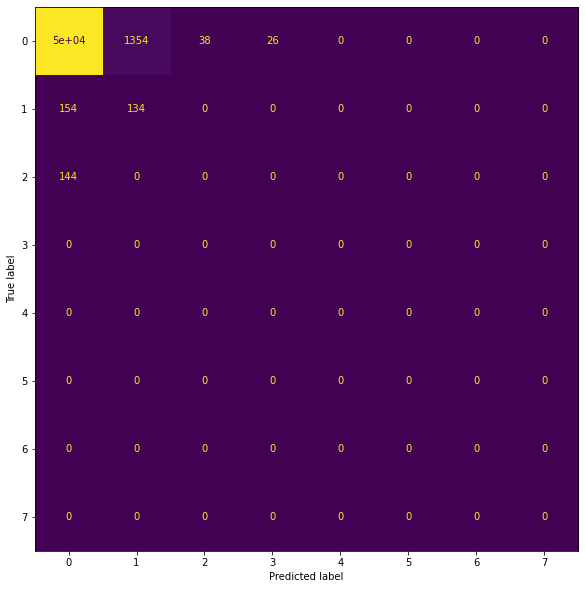

In [202]:
# matriz de clasificacion
y_pred, y_real, y_nwp = predicciones['y_pred'], predicciones['y_real'], predicciones['y_nwp']
pred = y_pred[..., 2:].astype(np.float32)
pred = torch.from_numpy(pred)
pred = torch.argmax(pred, dim=-1).float()
print(pred.shape)
pred = torch.mean(pred, dim=1)
pred = pred.reshape(-1).long()
print(pred[5000])
print(pred.shape)

real = y_real[..., 2:].astype(np.float32)
real = torch.from_numpy(real)
real = torch.argmax(real, dim=-1).float()
real = torch.mean(real, dim=1)
real = real.reshape(-1).long()
print(real[5000])
from sklearn.metrics import classification_report
print(classification_report(real, pred))

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(10,10))


ConfusionMatrixDisplay.from_predictions(real, pred, labels=range(8), colorbar=False, ax=ax)
plt.show()

/home/diego/anaconda3/envs/wcontrol/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/diego/anaconda3/envs/wcontrol/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/diego/anaconda3/envs/wcontrol/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.95      0.97     51408
           1       0.00      0.00      0.00       288
           2       0.00      0.00      0.00       144
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.94     51840
   macro avg       0.17      0.16      0.16     51840
weighted avg       0.99      0.94      0.97     51840



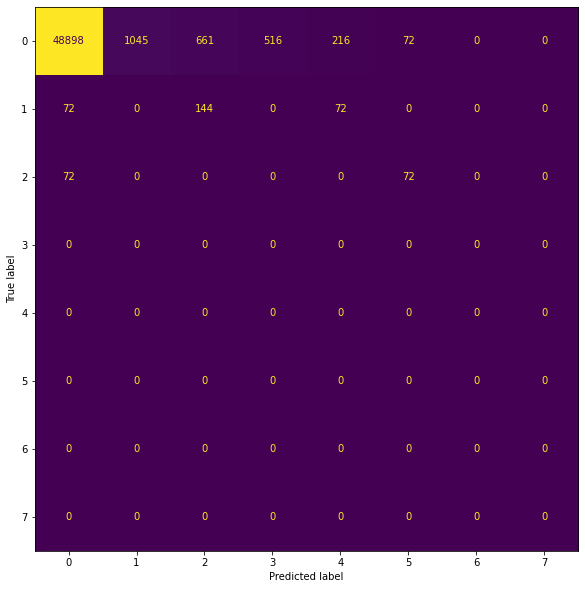

In [203]:
y_pred, y_real, y_nwp = predicciones['y_pred'], predicciones['y_real'], predicciones['y_nwp']
nwp = y_nwp[..., 2:].astype(np.float32)
nwp = torch.from_numpy(nwp)
nwp = torch.argmax(nwp, dim=-1).float()
nwp = torch.mean(nwp, dim=1)
nwp = nwp.reshape(-1).long()


real = y_real[..., 2:].astype(np.float32)
real = torch.from_numpy(real)
real = torch.argmax(real, dim=-1).float()
real = torch.mean(real, dim=1)
real = real.reshape(-1).long()
from sklearn.metrics import classification_report
print(classification_report(real, nwp))

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(10,10))

ConfusionMatrixDisplay.from_predictions(real, nwp, labels=range(8), colorbar=False, ax=ax)
plt.show()

### Evaluacion del modelo de parcela

In [204]:
with open("//home/diego/weather-control/experiments/experimentoFINAL/pmodel/outputs/hr/best/prediccion_test.pickle", 'rb') as handler:
    predicciones = pickle.load(handler)


In [205]:
y_pred, y_real, y_nwp = predicciones['y_pred'], predicciones['y_real'], predicciones['y_nwp']
y_nwp.shape

(2928, 72, 1)

In [207]:
with open("//home/diego/weather-control/experiments/experimentoFINAL/pmodel/outputs/hr/best/prediccion_test.pickle", 'rb') as handler:
    predicciones = pickle.load(handler)
y_pred, y_real, y_nwp = predicciones['y_pred'], predicciones['y_real'], predicciones['y_nwp']
MAE_t_z, MAE_hr_z, CEL_r_z = [], [], []
for idx in tqdm(range(len(y_pred))):
    MAE_hr_z.append(mean_absolute_error(y_real[idx].reshape(-1,1), y_nwp[idx].reshape(-1,1)))
resultados.loc['M. Parcela', [['MSE(y_real, AEMET)', 'HR1']]] = np.mean(MAE_hr_z, axis=0) * 100
MAE_t_z, MAE_hr_z, CEL_r_z = [], [], []
for idx in tqdm(range(len(y_pred))):
    MAE_hr_z.append(mean_absolute_error(y_real[idx].reshape(-1,1), y_pred[idx].reshape(-1,1)))
resultados.loc['M. Parcela', [['MSE(y_real, y_pred)', 'HR2']]] = np.mean(MAE_hr_z, axis=0) * 100

with open("//home/diego/weather-control/experiments/experimentoFINAL/pmodel/outputs/temperatura/best/prediccion_test.pickle", 'rb') as handler:
    predicciones = pickle.load(handler)
y_pred, y_real, y_nwp = predicciones['y_pred'], predicciones['y_real'], predicciones['y_nwp']
MAE_t_z, MAE_hr_z, CEL_r_z = [], [], []
for idx in tqdm(range(len(y_pred))):
    MAE_hr_z.append(mean_absolute_error(y_real[idx].reshape(-1,1), y_nwp[idx].reshape(-1,1)))
resultados.loc['M. Parcela', [['MSE(y_real, AEMET)', 'Temperatura1']]] = np.mean(MAE_hr_z, axis=0) * 100
for idx in tqdm(range(len(y_pred))):
    MAE_hr_z.append(mean_absolute_error(y_real[idx].reshape(-1,1), y_pred[idx].reshape(-1,1)))
resultados.loc['M. Parcela', [['MSE(y_real, y_pred)', 'Temperatura2']]] = np.mean(MAE_hr_z, axis=0) * 100
resultados


100%|██████████| 2928/2928 [00:00<00:00, 5397.24it/s]


MSE(y_real, AEMET)                          MSE(y_real, y_pred)  \
                 Temperatura1       HR1 Precipitacion1        Temperatura2   
M. Zonal             3.602177  5.768373       1.825524            2.245377   
M. Parcela           4.517538  6.779478            NaN            4.099472   

                                     
                 HR2 Precipitacion2  
M. Zonal    4.756782       1.268004  
M. Parcela  7.493049            NaN

(2928, 72, 8)
torch.Size([2928, 72])
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2928

    accuracy                           1.00      2928
   macro avg       1.00      1.00      1.00      2928
weighted avg       1.00      1.00      1.00      2928



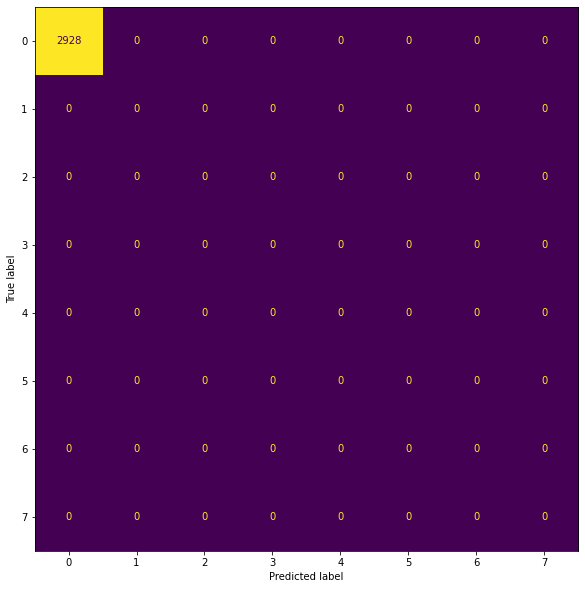

In [210]:
# matriz de clasificacion
with open("//home/diego/weather-control/experiments/experimentoFINAL/pmodel/outputs/precipitacion/best/prediccion_test.pickle", 'rb') as handler:
    predicciones = pickle.load(handler)
print(y_pred.shape)
y_pred, y_real, y_nwp = predicciones['y_pred'], predicciones['y_real'], predicciones['y_nwp']
pred = y_pred[...].astype(np.float32)
pred = torch.from_numpy(pred)
pred = torch.argmax(pred, dim=-1).float()
print(pred.shape)
pred = torch.mean(pred, dim=1)
pred = pred.reshape(-1).long()

real = y_real[...].astype(np.float32)
real = torch.from_numpy(real)
real = torch.argmax(real, dim=-1).float()
real = torch.mean(real, dim=1)
real = real.reshape(-1).long()
from sklearn.metrics import classification_report
print(classification_report(real, pred))

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(10,10))


ConfusionMatrixDisplay.from_predictions(real, pred, labels=range(8), colorbar=False, ax=ax)
plt.show()  

In [ ]:
y_pred, y_real, y_nwp = predicciones['y_pred'], predicciones['y_real'], predicciones['y_nwp']
nwp = y_nwp[..., 2:].astype(np.float32)
nwp = torch.from_numpy(nwp)
nwp = torch.argmax(nwp, dim=-1).float()
nwp = torch.mean(nwp, dim=1)
nwp = nwp.reshape(-1).long()


real = y_real[..., 2:].astype(np.float32)
real = torch.from_numpy(real)
real = torch.argmax(real, dim=-1).float()
real = torch.mean(real, dim=1)
real = real.reshape(-1).long()
from sklearn.metrics import classification_report
print(classification_report(real, nwp))

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(10,10))

ConfusionMatrixDisplay.from_predictions(real, nwp, labels=range(8), colorbar=False, ax=ax)
plt.show()